In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import scipy.io as sio
from matplotlib import rc

def set_style_sns():
    sns.set_context('paper')
    sns.set(font = 'serif')
    sns.set(font_scale = 1.3)
    
    sns.set_style('white', {
        'font.family': 'serif',
        'font.serif': ['Time', 'Palatino', 'serif'],
        'lines.markersize': 10
    })
    
    
plt.rcParams.update({'font.size':16})
set_style_sns()

plt.rcParams.update({'text.usetex': False})

In [2]:
data = sio.matlab.loadmat('../data/FlatBeam_NLResponse_RandVibe.mat')['out']
y = data[0]['def'][0].T[:, :, np.newaxis][:,10,:]
yv = data[0]['vel'][0].T[:, :, np.newaxis][:,10,:]
ya = data[0]['acc'][0].T[:, :, np.newaxis][:,10,:]
u = data[0]['fext'][0].T[:, :, np.newaxis][:,10,:]
t = data[0]['t'][0][0]

print(y.shape, u.shape, t.shape)

(10001, 1) (10001, 1) (10001,)


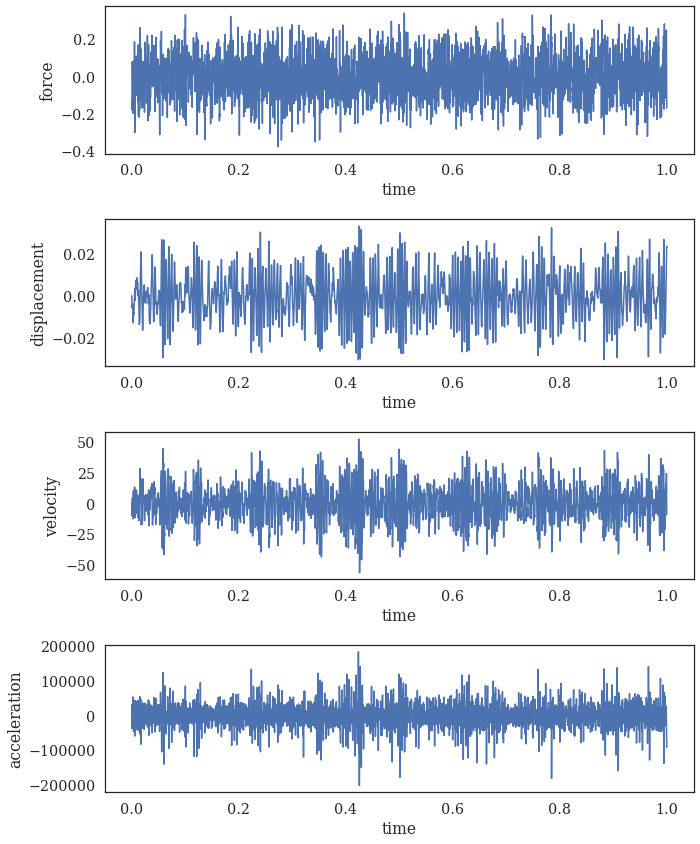

In [8]:
plt.figure(figsize=(10,12))
plt.subplot(4,1,1)
plt.plot(t,u)
plt.xlabel('time')
plt.ylabel('force')

plt.subplot(4,1,2)
plt.plot(t,y)
plt.xlabel('time')
plt.ylabel('displacement')

plt.subplot(4,1,3)
plt.plot(t,yv)
plt.xlabel('time')
plt.ylabel('velocity')

plt.subplot(4,1,4)
plt.plot(t,ya)
plt.xlabel('time')
plt.ylabel('acceleration')

plt.tight_layout()
plt.show()

[[3.31365126e-02]
 [5.66465450e+01]
 [2.02096860e+05]]
5000


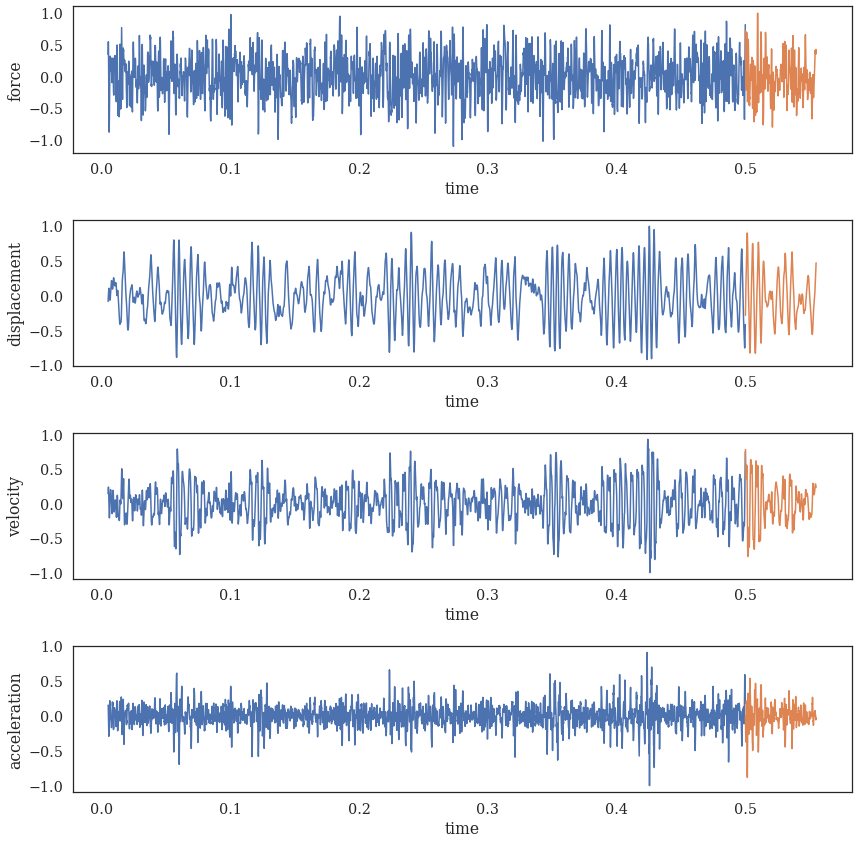

In [55]:
umax = np.max(u)
ymax = np.max(np.abs([y,yv,ya]), axis = 1)
print(ymax)

u_norm = u/umax
y_norm = y/ymax[0]
yv_norm = yv/ymax[1]
ya_norm = ya/ymax[2]

N = len(u)
ntrain = int(N*0.5)
start = 50

print(ntrain)
utrain = u_norm[start:ntrain]
ytrain = y_norm[start:ntrain]
yvtrain = yv_norm[start:ntrain]
yatrain = ya_norm[start:ntrain]
ttrain = t[start:ntrain]
intrain = np.hstack([utrain,ytrain,yvtrain,yatrain])
outtrain = np.hstack([ytrain,yvtrain,yatrain])

utest = u_norm[ntrain:start+ntrain+500]
ytest = y_norm[ntrain:start+ntrain+500]
yvtest = yv_norm[ntrain:start+ntrain+500]
yatest = ya_norm[ntrain:start+ntrain+500]
ttest = t[ntrain:start+ntrain+500]
intest = np.hstack([utest,ytest,yvtest,yatest])
outtest = np.hstack([ytest,yvtest,yatest])

ufull = np.concatenate([utrain, utest], axis = 0)
yfull = np.concatenate([ytrain, ytest], axis = 0)
infull = np.concatenate([intrain, intest], axis = 0)
outfull = np.concatenate([outtrain, outtest], axis = 0)

plt.figure(figsize=(12,12))
plt.subplot(4,1,1)
plt.plot(ttrain,utrain)
plt.plot(ttest,utest)
plt.xlabel('time')
plt.ylabel('force')

plt.subplot(4,1,2)
plt.plot(ttrain,ytrain)
plt.plot(ttest,ytest)
plt.xlabel('time')
plt.ylabel('displacement')

plt.subplot(4,1,3)
plt.plot(ttrain,yvtrain)
plt.plot(ttest,yvtest)
plt.xlabel('time')
plt.ylabel('velocity')

plt.subplot(4,1,4)
plt.plot(ttrain,yatrain)
plt.plot(ttest,yatest)
plt.xlabel('time')
plt.ylabel('acceleration')

plt.tight_layout()
plt.show()

In [56]:
def create_inout_sequences(input_data, output_data, tw):
    xs = []
    ys = []

    for i in range(len(input_data)-tw-1):
        xya = input_data[i:(i+tw), 3]
        xyv = input_data[i:(i+tw), 2]
        xy = input_data[i:(i+tw), 1]
        xu = input_data[i+1:(i+tw)+1, 0]
        x = np.vstack([xu,xy,xyv,xya])
        y = output_data[i+tw,:]

        xs.append(x)
        ys.append(y)

    return np.transpose(np.array(xs),[0,1,2]), np.array(ys)

In [57]:
train_window = 24

x_train, y_train = create_inout_sequences(intrain, outtrain, train_window)
x_val, y_val = create_inout_sequences(intest, outtest, train_window)

x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()

x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).float()

print(x_train.shape, y_train.shape)

x_full, y_full = create_inout_sequences(infull, outfull, train_window)

x_full = torch.from_numpy(x_full).float()
y_full = torch.from_numpy(y_full).float()

print(x_full.shape, y_full.shape)

torch.Size([4925, 4, 24]) torch.Size([4925, 3])
torch.Size([5475, 4, 24]) torch.Size([5475, 3])


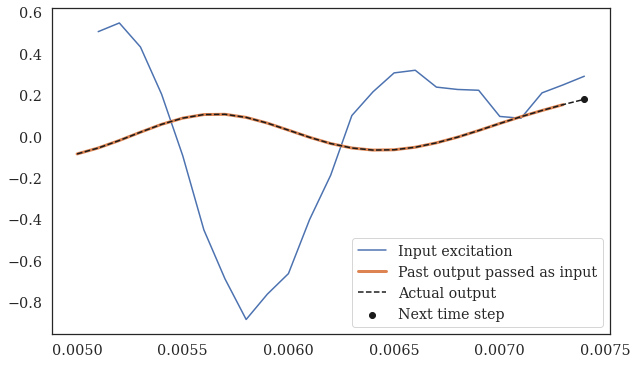

In [29]:
plt.figure(figsize=(10,6))
plt.plot(ttrain[1:train_window+1], x_train[0,0,:])
plt.plot(ttrain[:train_window], x_train[0,1,:], linewidth = 3)
plt.scatter(ttrain[train_window], y_train[0], color = 'k')
plt.plot(ttrain[:train_window + 1], ytrain[:train_window + 1], 'k--')
plt.legend(['Input excitation', 'Past output passed as input', 
           'Actual output', 'Next time step'], loc = 'best')
plt.show()

In [62]:
M = 2
alpha = [-1., 1., 0.]
beta = [0., 1.5, -0.5]

def RK_check(x, dx, dt, scalers, M = 2, alpha = [-1., 1., 0.], beta = [0., 1.5, -0.5]):
    x = x*scalers[:-1].T
    dx = dx*scalers[1:].T

    Y = alpha[0]*x[M:, :] + dt*beta[0]*dx[M:, :]
        
    for m in range(1, M+1):
        Y = Y + alpha[m]*x[M-m:-m, :] + dt*beta[m]*dx[M-m:-m,:]
        
    return Y/scalers[:-1].T*1e-1

dt = ttrain[1] - ttrain[0]

X = y_train[:, :-1]
DX = y_train[:, 1:]

print(ymax)

RK_check(X, DX, dt, ymax)


[[3.31365126e-02]
 [5.66465450e+01]
 [2.02096860e+05]]


tensor([[ 1.4645e-04, -1.9714e-04],
        [ 5.3383e-05, -8.9162e-04],
        [-4.4884e-05, -2.5805e-04],
        ...,
        [ 4.1576e-05,  1.2034e-03],
        [ 1.4845e-04,  4.6968e-05],
        [ 3.4836e-04,  2.2918e-03]], dtype=torch.float64)

In [23]:
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils import weight_norm


class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


In [24]:
import torch.nn.functional as F


class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, seq_len, dropout):
        super(TCN, self).__init__()
        self.seq_len = seq_len
        self.num_channels = num_channels
        self.tcn = TemporalConvNet(input_size, num_channels, kernel_size, dropout=dropout)
        self.linear = nn.Linear(num_channels[-1]*seq_len, output_size)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        # x needs to have dimension (N, C, L) in order to be passed into CNN
        output = self.tcn(x).transpose(1, 2).reshape((-1, self.seq_len*self.num_channels[-1]))
        output = self.linear(output).double()
        return output

In [63]:
model = TCN(input_size = 4, 
            output_size = 3, 
            num_channels = [6]*6, 
            kernel_size = 3, 
            seq_len = train_window, 
            dropout = 0.1)

In [68]:
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = torch.nn.MSELoss(reduction = "sum")

def train(model,epoch, X_train, Y_train, batch_size):
    global lr
    model.train()
    batch_idx = 1
    total_loss = 0
    for i in range(0, X_train.size(0), batch_size):
        if i + batch_size > X_train.size(0):
            x, y = X_train[i:, :, :], Y_train[i:]
        else:
            x, y = X_train[i:(i+batch_size), :, :], Y_train[i:(i+batch_size)]
        optimizer.zero_grad()
        output = model(x)
        
        # check derivatives
        X = output[:, :-1]
        DX = output[:, 1:]
        
        residual = RK_check(X, DX, dt, torch.from_numpy(ymax))

        loss = F.mse_loss(output, y.double()) + F.mse_loss(residual, torch.zeros(residual.shape).double())

        loss.backward()

        optimizer.step()
        batch_idx += 1
        total_loss += loss.item()

        if batch_idx % 25 == 0:
            cur_loss = total_loss / 25
            processed = min(i+batch_size, X_train.size(0))
            print('Train Epoch: {:2d} [{:6d}/{:6d} ({:.0f}%)]\tLearning rate: {:.4f}\tLoss: {:.6f}'.format(
                epoch, processed, X_train.size(0), 100.*processed/X_train.size(0), lr, cur_loss))
            total_loss = 0


def evaluate(model, X_test, Y_test):
    #model.eval()
    with torch.no_grad():
        output = model(X_test)
        test_loss = F.mse_loss(output, Y_test)
        print('\nTest set: Average loss: {:.6f}\n'.format(test_loss.item()))
        return test_loss.item()

In [116]:
epochs = 50000
batch_size = 250

for ep in range(1, epochs+1):
    train(model, ep, x_train, y_train, batch_size)
    print('Epoch: {}'.format(ep))
    tloss = evaluate(model, x_val, y_val)


Epoch: 1

Test set: Average loss: 0.000035

Epoch: 2

Test set: Average loss: 0.000036

Epoch: 3

Test set: Average loss: 0.000034

Epoch: 4

Test set: Average loss: 0.000036

Epoch: 5

Test set: Average loss: 0.000032

Epoch: 6

Test set: Average loss: 0.000036

Epoch: 7

Test set: Average loss: 0.000029

Epoch: 8

Test set: Average loss: 0.000034

Epoch: 9

Test set: Average loss: 0.000033

Epoch: 10

Test set: Average loss: 0.000031

Epoch: 11

Test set: Average loss: 0.000037

Epoch: 12

Test set: Average loss: 0.000031

Epoch: 13

Test set: Average loss: 0.000034

Epoch: 14

Test set: Average loss: 0.000036

Epoch: 15

Test set: Average loss: 0.000032

Epoch: 16

Test set: Average loss: 0.000031

Epoch: 17

Test set: Average loss: 0.000030

Epoch: 18

Test set: Average loss: 0.000033

Epoch: 19

Test set: Average loss: 0.000033

Epoch: 20

Test set: Average loss: 0.000041

Epoch: 21

Test set: Average loss: 0.000029

Epoch: 22

Test set: Average loss: 0.000035

Epoch: 23

Test set

Epoch: 182

Test set: Average loss: 0.000037

Epoch: 183

Test set: Average loss: 0.000036

Epoch: 184

Test set: Average loss: 0.000035

Epoch: 185

Test set: Average loss: 0.000030

Epoch: 186

Test set: Average loss: 0.000036

Epoch: 187

Test set: Average loss: 0.000031

Epoch: 188

Test set: Average loss: 0.000036

Epoch: 189

Test set: Average loss: 0.000036

Epoch: 190

Test set: Average loss: 0.000029

Epoch: 191

Test set: Average loss: 0.000031

Epoch: 192

Test set: Average loss: 0.000035

Epoch: 193

Test set: Average loss: 0.000032

Epoch: 194

Test set: Average loss: 0.000035

Epoch: 195

Test set: Average loss: 0.000031

Epoch: 196

Test set: Average loss: 0.000037

Epoch: 197

Test set: Average loss: 0.000037

Epoch: 198

Test set: Average loss: 0.000037

Epoch: 199

Test set: Average loss: 0.000036

Epoch: 200

Test set: Average loss: 0.000032

Epoch: 201

Test set: Average loss: 0.000033

Epoch: 202

Test set: Average loss: 0.000034

Epoch: 203

Test set: Average loss

KeyboardInterrupt: 

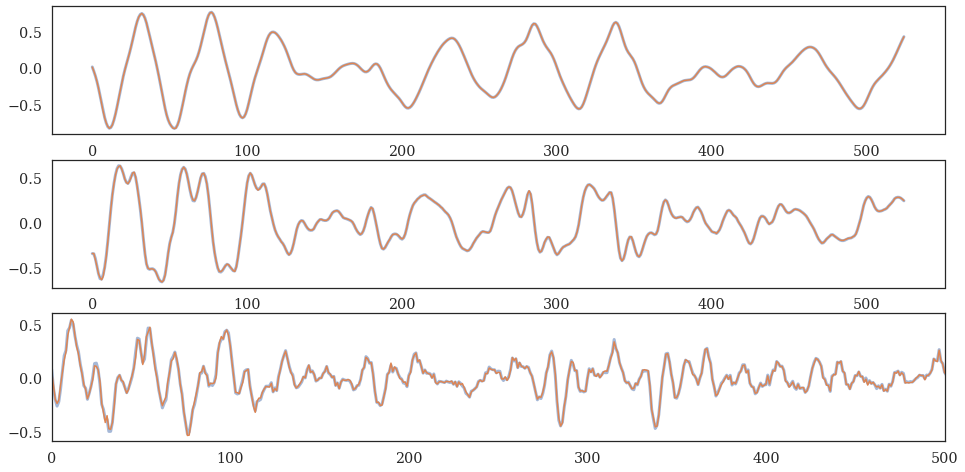

In [117]:
ypred = model(x_val)

plt.figure(figsize = (16, 8))

for ii in range(3):
    plt.subplot(3,1,ii+1)
    plt.plot(y_val[:,ii], linewidth = 3, alpha = 0.5)
    plt.plot(ypred.detach().numpy()[:,ii])

plt.xlim([0,500])
plt.show()

In [118]:
ypred.detach().numpy().shape

(525, 3)

In [119]:

def simulate(x0, u, future):
    tw = x0.shape[-1]
    feats = x0.shape[0]

    x_ = x0.reshape((1,feats,tw))
    x = x0
    ypred = model(x_)
    
    for ii in range(1,future):

        new_pair = np.hstack([u[tw + ii][0].reshape((1,1)), ypred.detach().numpy()]).reshape((feats,-1))
        x = np.concatenate([x, new_pair], axis = -1)
        
        x_ = x[:, -tw:].reshape((1, feats, tw))
        x_ = torch.from_numpy(x_)
        ypred = model(x_.float())

    return x

In [125]:
x0 = x_val[0]
ypred_sim = simulate(x0, utest, 500)
ypred_sim = ypred_sim[1:,train_window:]

In [126]:
ypred_sim.shape

(3, 499)

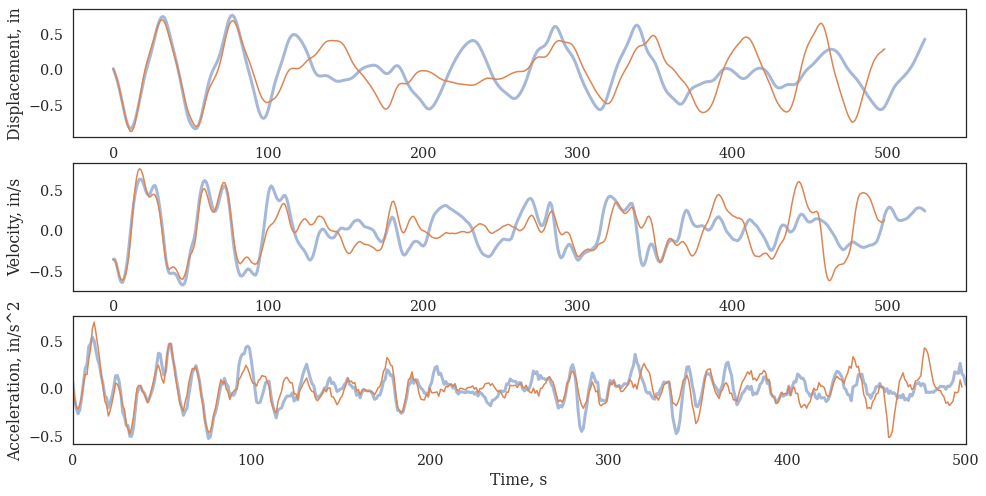

In [128]:

plt.figure(figsize = (16, 8))

plt.plot(y_val, linewidth = 3, alpha = 0.5)
plt.plot(ypred_sim.T)

ylbl = ['Displacement, in', 'Velocity, in/s', 'Acceleration, in/s^2']
for ii in range(3):
    plt.subplot(3,1,ii+1)
    plt.plot(y_val[:,ii], linewidth = 3, alpha = 0.5)
    plt.plot(ypred_sim[ii,:])


    plt.ylabel(ylbl[ii])
    plt.xlabel('Time, s')

plt.xlim([0,500])
plt.show()

In [129]:
utest.shape
u_norm.shape
print(y_full.shape)

torch.Size([5475, 3])


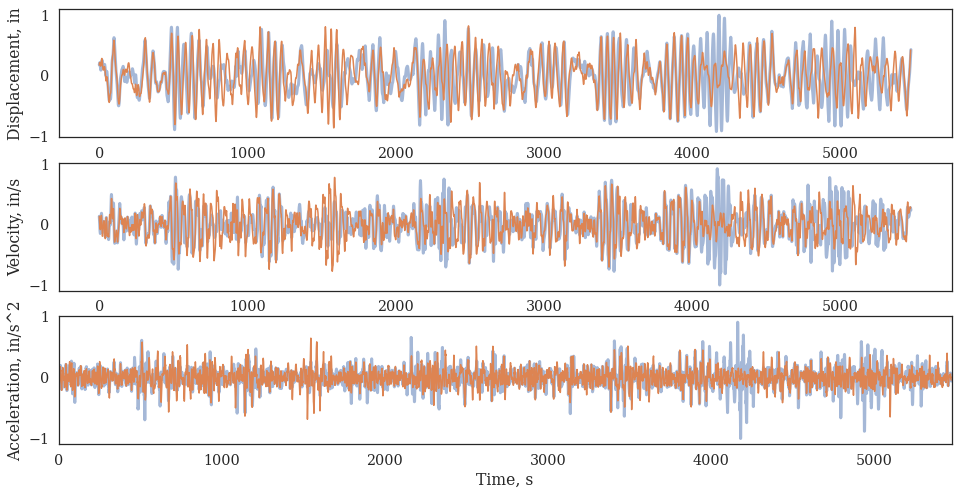

In [132]:
x0 = x_full[0]
npred = x_full.shape[0] - 1
ypred_sim = simulate(x0, ufull, npred)
ypred_sim = ypred_sim[1:,train_window:]

plt.figure(figsize = (16, 8))

for ii in range(3):
    plt.subplot(3,1,ii+1)
    plt.plot(y_full[:,ii], linewidth = 3, alpha = 0.5)
    plt.plot(ypred_sim[ii,:])


    plt.ylabel(ylbl[ii])
    plt.xlabel('Time, s')

plt.xlim([0,npred])
plt.show()

In [131]:
ypred_sim.shape

(5473,)

In [104]:
nchannels = [3, 6, 9]
nlayers = [3, 5, 7]
kernelsize = [3]

epochs = 500
batch_size = 250

hyperparams = []

for nc in nchannels:
    for nl in nlayers:
        for ks in kernelsize:
            model = TCN(input_size = 2, 
                        output_size = 1, 
                        num_channels = [nc]*nl, 
                        kernel_size = ks, 
                        seq_len = train_window, 
                        dropout = 0.1)
            print([nc]*nl)
            for ep in range(1, epochs+1):
                train(model, ep, x_train, y_train, batch_size)
                if ep % 50 == 0:
                    print('Epoch: {}'.format(ep))
                    tloss = evaluate(model, x_val, y_val)
            
            hyperparams.append([nc, nl, ks, tloss])
            print(hyperparams[-1])
            
pickle.dump(hyperparams, open('hyperparam_runs.pickle', 'wb'))


[3, 3, 3]
Epoch: 50

Test set: Average loss: 1.173970

Epoch: 100

Test set: Average loss: 1.164860

Epoch: 150

Test set: Average loss: 1.174647

Epoch: 200

Test set: Average loss: 1.169710

Epoch: 250

Test set: Average loss: 1.175539

Epoch: 300

Test set: Average loss: 1.177534

Epoch: 350

Test set: Average loss: 1.175668

Epoch: 400

Test set: Average loss: 1.165821

Epoch: 450

Test set: Average loss: 1.174930

Epoch: 500

Test set: Average loss: 1.190137

[3, 3, 3, 1.1901369514374631]
[3, 3, 3, 3, 3]
Epoch: 50

Test set: Average loss: 0.244408

Epoch: 100

Test set: Average loss: 0.248154

Epoch: 150

Test set: Average loss: 0.246772

Epoch: 200

Test set: Average loss: 0.248602

Epoch: 250

Test set: Average loss: 0.248202

Epoch: 300

Test set: Average loss: 0.240986

Epoch: 350

Test set: Average loss: 0.247317

Epoch: 400

Test set: Average loss: 0.244650

Epoch: 450

Test set: Average loss: 0.244559

Epoch: 500

Test set: Average loss: 0.245608

[3, 5, 3, 0.24560780395239

NameError: name 'pickle' is not defined

In [105]:
import pickle 
pickle.dump(hyperparams, open('hyperparam_runs.pickle', 'wb'))

In [106]:
hyperparams

[[3, 3, 3, 1.1901369514374631],
 [3, 5, 3, 0.2456078039523973],
 [3, 7, 3, 0.5105965993993377],
 [6, 3, 3, 0.11973414125472952],
 [6, 5, 3, 0.5458264064765384],
 [6, 7, 3, 0.20835276448076956],
 [9, 3, 3, 0.14021653580262358],
 [9, 5, 3, 0.27441562471524916],
 [9, 7, 3, 0.13629748571598935]]

In [109]:
from statsmodels.tsa.arima_model import ARMA

ModuleNotFoundError: No module named 'statsmodels'